In [1]:
#calcular parâmetros das galáxias
#EM CONSTRUÇÃO!
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import LogStretch
from matplotlib.colors import LogNorm
from astropy.modeling import models
from astropy.utils.data import get_pkg_data_filename
import photutils
import time
import statmorph
import scipy.ndimage as ndi

def normalize(image):
    m, M = np.min(image), np.max(image)
    return (image-m) / (M-m)

Filename: /home/JackS/Documentos/python/galaxies/UM456_full.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     215   (996, 2048)   float32   
Original
Nível de fundo = 0.225261
Ruído de fundo = 0.021190
Subtraido
Nível de fundo = 0.000000
Ruído de fundo = 0.021190


<IPython.core.display.Javascript object>


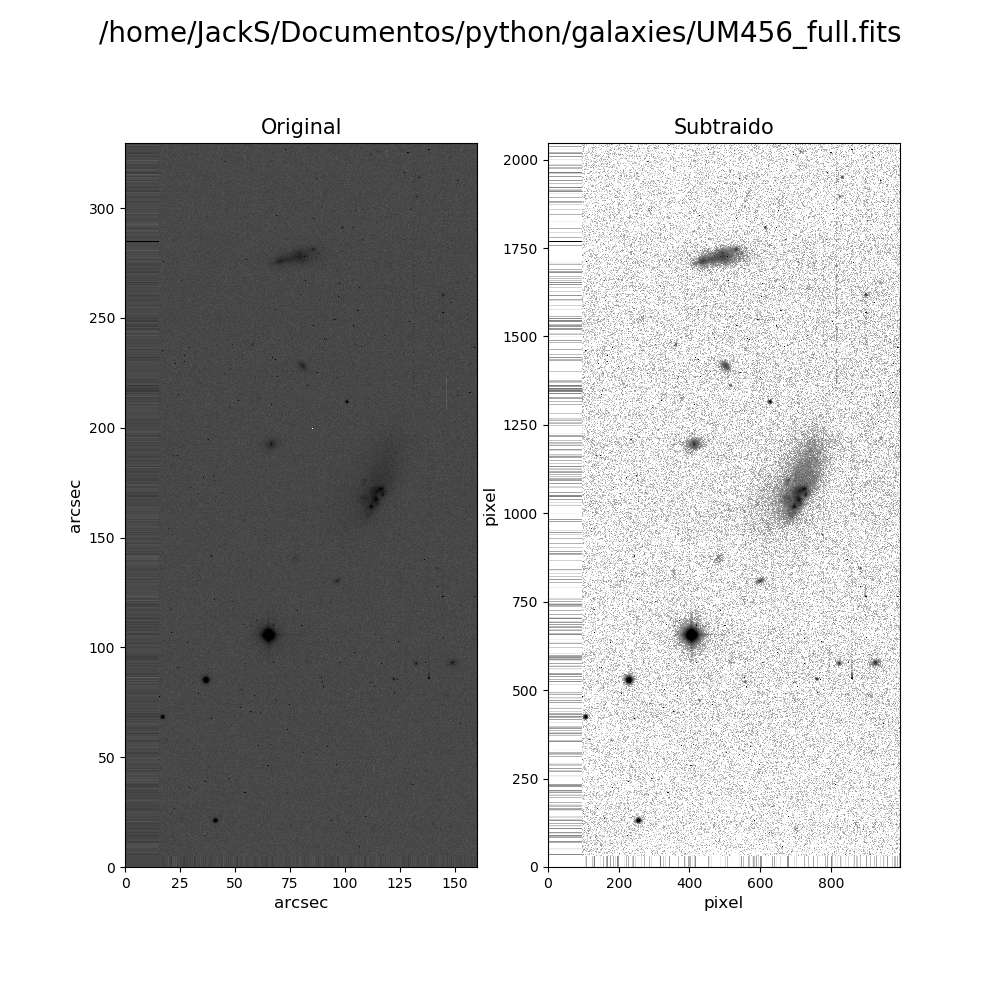

In [2]:
#Full image + backgoround + noise
from astropy.io import fits
from copy import deepcopy

#IMAGEM
filename = 'UM456'

image_full='/home/JackS/Documentos/python/galaxies/'+filename+'_full.fits'
#image_full = get_pkg_data_filename(image_full) #Info WCS
fits.info(image_full)

FITSe = fits.open(image_full)
FITSe = FITSe[0].data
FITS = deepcopy(FITSe)
x , y = FITSe.shape[1] , FITSe.shape[0] #limite dos eixos usado para formatar os axis image. (tbm pode ser usado FITSe[0].header[3] e 4)
#------------------------------
weight = '/home/JackS/Documentos/python/galaxies/'+filename+'-map_rms.fits'   #Importe o mapa de peso. Estatística de Poisson.
MAP_RMS = fits.open(weight)
map_rms = MAP_RMS[0].data
#------------------------------
MASK = 'mask_px.fits'        #Importe a máscara.
Mask = fits.open(MASK)
Mask = Mask[0].data
#------------------------------
SEGMAP = '/home/JackS/Documentos/python/galaxies/'+filename+'-segmentation.fits'  #Importe o mapa de segmentação. OPICIONAL se for usar sextractor
Segmap = fits.open(SEGMAP)
Segmap = Segmap[0].data
#------------------------------
from astropy.stats import sigma_clipped_stats  #Estatistica sigma clipped
mean , median , std = sigma_clipped_stats( FITSe, sigma = 3. )
print('Original')
print('Nível de fundo = %f'%(median))
print('Ruído de fundo = %f'%(std))

FITSe -= median  #subtraindo o background

mean , median , std = sigma_clipped_stats( FITSe, sigma = 3. )
print('Subtraido')
print('Nível de fundo = %f'%(median))
print('Ruído de fundo = %f'%(std))

#--------------------------
#Plot das imagens
fig ,(ax1 , ax2) = plt.subplots(1,2,figsize=(10, 10))
fig.suptitle(image_full, fontsize=20)
#import matplotlib.ticker as ticker
#ax1.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax1.set_xlabel('arcsec',fontsize=12)
ax1.set_ylabel('arcsec',fontsize=12)
ax1.set_title('Original',fontsize=15)
ax1.imshow(FITS, origin='lower', cmap='gray_r',norm=LogNorm(vmin=0.005, vmax=1.0),extent=[0,x*0.161,0,y*0.161])
ax1.set_aspect(1)

ax2.set_xlabel('pixel',fontsize=12)
ax2.set_ylabel('pixel',fontsize=12)
ax2.set_title('Subtraido',fontsize=15)
ax2.imshow(FITSe, origin='lower', cmap='gray_r',norm=LogNorm(vmin=0.005, vmax=1.0))


In [3]:
#FITS = FITSe
GHII = FITS[844:1244,506:906]  # [y1:y2,x1:x2] . obs:Já está em FITS[0].data
image_star = FITS[1264:1364,576:676]
#image_star = FITS[320:420,832:932]
map_rms = map_rms[844:1244,506:906]
Mask = Mask[844:1244,506:906]
Segmap = Segmap[844:1244,506:906]

Nível de fundo = 0.232951
Ruído de fundo = 0.024362
[[-0.04557112  0.00327316  0.05805536 ... -0.01876777 -0.00883657
  -0.02452627]
 [ 0.00272374 -0.01169817 -0.0306554  ...  0.00316785 -0.00251324
  -0.01713157]
 [ 0.00506239  0.01201391 -0.0149105  ... -0.01383966 -0.00414135
   0.01641919]
 ...
 [-0.01116194 -0.02539518 -0.0118067  ... -0.02361785  0.0103393
  -0.00804998]
 [ 0.00533815 -0.03022371 -0.06245624 ...  0.00755307  0.01177971
   0.00717154]
 [-0.05003853 -0.00130624 -0.02064088 ... -0.01106068  0.00638683
   0.00495304]]
400


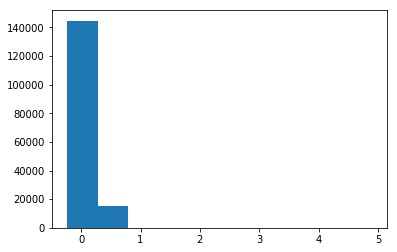

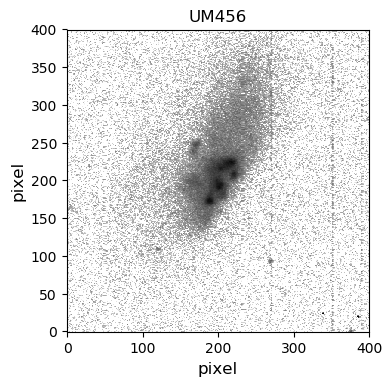

In [4]:
#Galáxia
%matplotlib inline
image_data = GHII
NBINS = 10
histogram = plt.hist(image_data.flatten(), NBINS) #histograma usado para saber os limites de pixel

mean , median , std = sigma_clipped_stats( image_data, sigma = 3. )
print('Nível de fundo = %f'%(median))
print('Ruído de fundo = %f'%(std))
image_data-=median

fig = plt.figure(dpi=100, edgecolor='white')
ax = fig.add_subplot(111)
plt.title(filename)
plt.xlabel('pixel',fontsize=12)
plt.ylabel('pixel',fontsize=12)

print(image_data)
print(len(image_data))
plt.imshow(image_data, origin='lower', cmap='gray_r',norm=LogNorm(vmin=0.005, vmax=1.0))
#plt.savefig(GHII+'_ori.png')

#image_data.writeto( 'new_'+filename+'.fits',overwrite='true',checksum='true' ) #Cria um fits novo 

Nível de fundo = 0.226122
Ruído de fundo = 0.020658
[[ 0.02076454  0.04352799  0.02554885 ... -0.00887839  0.01588741
  -0.02979216]
 [ 0.00592875  0.01536976 -0.03682487 ... -0.03239432 -0.02471535
  -0.0099041 ]
 [ 0.0116768  -0.00427489  0.03138208 ... -0.00275525 -0.01238604
   0.00442889]
 ...
 [-0.00623859  0.02864638  0.00068542 ...  0.03072023 -0.03989641
  -0.04157983]
 [-0.01666941  0.00438616 -0.01647279 ... -0.01886272 -0.00092568
   0.03618965]
 [-0.01296438 -0.00806463 -0.0009575  ...  0.00936654  0.02349073
  -0.00755665]]
100


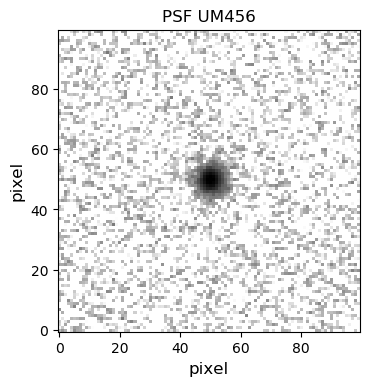

In [5]:
#Estrela PSF
psf = image_star

median = np.median(psf)
mean , median , std = sigma_clipped_stats( psf , sigma = 3. )
print('Nível de fundo = %f'%(median))
print('Ruído de fundo = %f'%(std))

psf -= median
fig = plt.figure(dpi=100, edgecolor='white')
ax = fig.add_subplot(111)
plt.title('PSF '+filename)
plt.xlabel('pixel',fontsize=12)
plt.ylabel('pixel',fontsize=12)
plt.imshow(psf, origin='lower', cmap='gray_r',norm=LogNorm(vmin=0.005, vmax=1.0))
print(psf) #Matriz estrela
print(len(psf))

[[0.02013917 0.02013908 0.02013885 ... 0.02062214 0.02060335 0.02058495]
 [0.02014972 0.02014976 0.02014964 ... 0.02061555 0.02059699 0.02057883]
 [0.02015944 0.02015959 0.02015956 ... 0.02060909 0.02059077 0.02057286]
 ...
 [0.0200584  0.0200662  0.02007393 ... 0.02075317 0.02074822 0.02074341]
 [0.02005566 0.02006352 0.02007131 ... 0.02074984 0.02074448 0.02073929]
 [0.02005314 0.02006105 0.02006889 ... 0.02074718 0.02074142 0.02073583]]
400


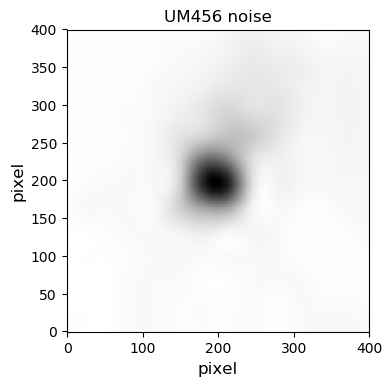

In [6]:
#mapa RMS - weight maps

fig = plt.figure(dpi=100, edgecolor='white')
ax = fig.add_subplot(111)
plt.title(filename+' noise')
plt.xlabel('pixel',fontsize=12)
plt.ylabel('pixel',fontsize=12)
plt.imshow(map_rms, origin='lower', cmap='gray_r')
print(map_rms) #Matriz mapa de pixel da galáxia
print(len(map_rms))
#plt.savefig(GHII+'_object.png')

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


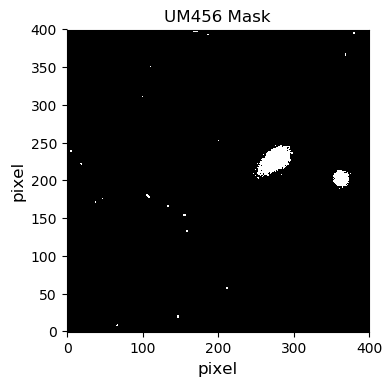

In [7]:
#Fase de TESTE - FLAG derivado do WW, como mask 
#Imagem mask. Estou usando uma matriz 2D 0 e 1
#A mascara é uma matriz booleana que determina os pixels a serem desconsiderados. True é desconsiderado.

Mask = Mask >= 1  #transforma em matriz booleana

fig = plt.figure(dpi=100, edgecolor='white')
ax = fig.add_subplot(111)
plt.title(filename+' Mask')
plt.xlabel('pixel',fontsize=12)
plt.ylabel('pixel',fontsize=12)
plt.imshow(Mask, origin='lower',  cmap='gray')
print(Mask)
#plt.savefig(GHII+'_mask.png')

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


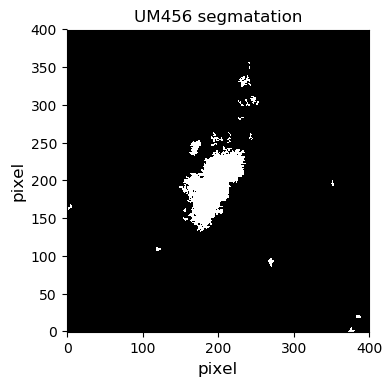

In [8]:
#Segmentação derivada do SEXTRACTOR
segmap = Segmap
segmap= segmap > 0.1
fig = plt.figure(dpi=100, edgecolor='white')
ax = fig.add_subplot(111)
plt.title(filename+' segmatation')
plt.xlabel('pixel',fontsize=12)
plt.ylabel('pixel',fontsize=12)
plt.imshow(segmap, origin='lower', cmap='gray')
print(segmap)

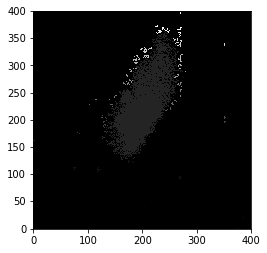

In [9]:
# Segmentação derivada da tarefa PHOTOTUTILS
#O SExtractor é indicado para fazer o mapa de segmentação. Segmap
threshold = photutils.detect_threshold(image_data, snr=1.5)
npixels =8  # minimum number of connected pixels
segm = photutils.detect_sources(image_data, threshold, npixels)
plt.imshow(segm, origin='lower', cmap='gray')

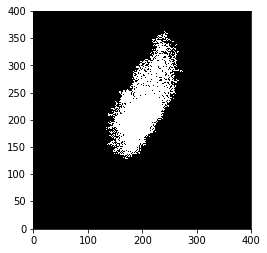

In [10]:
# Keep only the largest segment
label = np.argmax(segm.areas) + 1
segmap = segm.data == label
plt.imshow(segmap, origin='lower', cmap='gray')

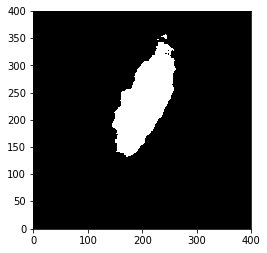

In [11]:
segmap_float = ndi.uniform_filter(np.float64(segmap), size=10)
segmap = segmap_float > 0.5
plt.imshow(segmap, origin='lower', cmap='gray')

#plt.savefig(GHII+'_segment.png')

In [12]:
#Se tiver fontes sobrepostas usar
#objeto.deblend_sources() #para alterar as fontes.

#Agora que temos todos os dados necessários
#Gain=1000.0 #Assumindo que existe uma média de mil elétrons / pixel no raio efetivo - gain=Gain
#Ou Pode ser substituido(Gain) por uma matriz 2D weightmap=m_pixel, fornecida pelo SExtractor
start = time.time() #Tempo total do processo
source_morphs = statmorph.source_morphology(image_data, segmap, weightmap=map_rms, psf=psf, niter_bh_mid=100, eta=0.2)
print('Time: %g s.' % (time.time() - start))

In [15]:
morph = source_morphs[0]
print('xc_centroid =', morph.xc_centroid)
print('yc_centroid =', morph.yc_centroid)
print('ellipticity_centroid =', morph.ellipticity_centroid)
print('elongation_centroid =', morph.elongation_centroid)
print('orientation_centroid =', morph.orientation_centroid)
print('xc_asymmetry =', morph.xc_asymmetry)
print('yc_asymmetry =', morph.yc_asymmetry)
print('ellipticity_asymmetry =', morph.ellipticity_asymmetry)
print('elongation_asymmetry =', morph.elongation_asymmetry)
print('orientation_asymmetry =', morph.orientation_asymmetry)
print('Asymmetry as described in Lotz et al. (2004) =',morph.asymmetry)
print('rpetro_circ =', morph.rpetro_circ)
print('rpetro_ellip =', morph.rpetro_ellip)
print('rhalf_circ =', morph.rhalf_circ)
print('rhalf_ellip =', morph.rhalf_ellip)
print('r20 =', morph.r20)
print('r50 =', morph.r50)
print('r80 =', morph.r80)
print('Gini =', morph.gini)
print('M20 =', morph.m20)
print('F(G, M20) =', morph.gini_m20_bulge)
print('S(G, M20) =', morph.gini_m20_merger)
print('sn_per_pixel =', morph.sn_per_pixel)
print('C =', morph.concentration)
print('A , asymmetry as described in Lotz et al. (2004) =', morph.asymmetry)
print('S , smoothness as described in Conselice (2003) =', morph.smoothness)
print('Shape asymmetry as described in Pawlik et al. (2016) =', morph.shape_asymmetry)
print('sersic_amplitude =', morph.sersic_amplitude)
print('sersic_rhalf =', morph.sersic_rhalf)
print('sersic_n =', morph.sersic_n)
print('sersic_xc =', morph.sersic_xc)
print('sersic_yc =', morph.sersic_yc)
print('sersic_ellip =', morph.sersic_ellip)
print('sersic_theta =', morph.sersic_theta)
print('sky_mean, mean background value =', morph.sky_mean)
print('sky_median, median background =', morph.sky_median)
print('sky_sigma, std devia. background =', morph.sky_sigma)
print('flag =', morph.flag)
print('flag_sersic =', morph.flag_sersic)
print('r50 em arcsec =',morph.r50*0.161)
print('rpetro_circ em arcsec =', morph.rpetro_circ*0.161)
print('rpetro_ellip em arcsec =', morph.rpetro_ellip*0.161)
print('Retorna o eixo semi-principal da elipse mínima =',morph.rmax_ellip)
print('O eixo semi-principal de uma abertura elíptica contendo 50% da luz =',morph.rhalf_ellip)
print('O eixo semi-principal de uma abertura elíptica contendo 50% da luz em arcseg =',morph.rhalf_ellip*0.161)
print('Fluxpetro_c, Return the sum of the pixel values over a circle aperture = ',morph.flux_circ)
print('Fluxpetro_e, Return the sum of the pixel values over a elliptical aperture =',morph.flux_ellip)
print('Intensity statistic as described in Peth et al. (2016) =',morph.intensity)
print('Desviation statistic as described in Peth et al. (2016) =',morph.deviation) 
print('Multimode statistic as described in Freeman et al. (2013) =',morph.multimode)

NameError: name 'source_morphs' is not defined

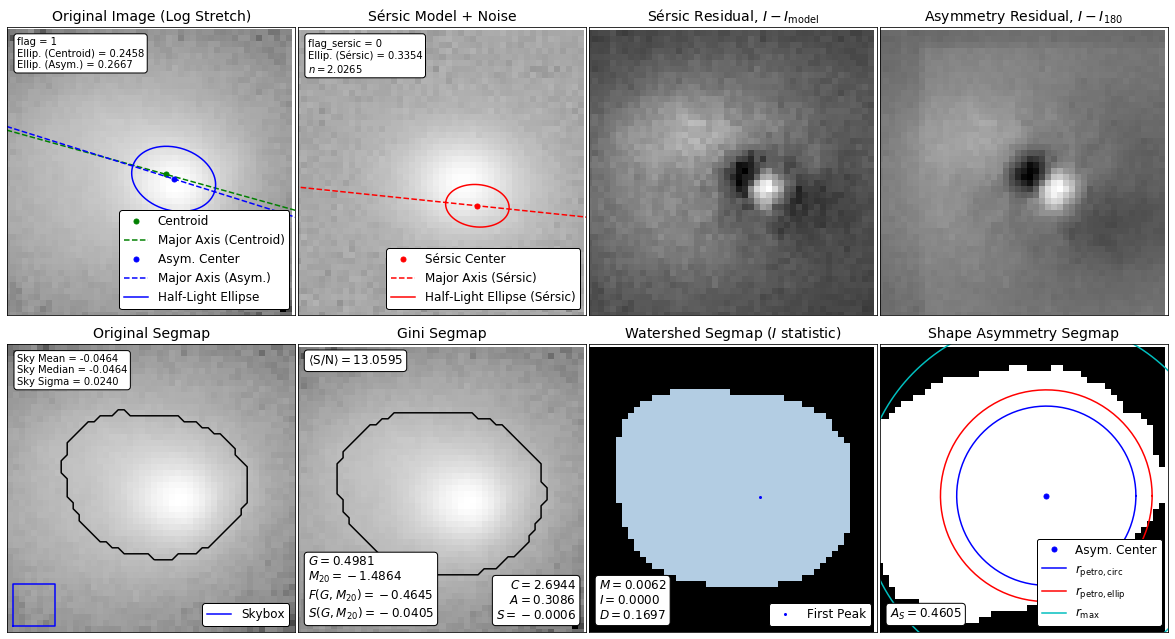

In [281]:
from statmorph.utils.image_diagnostics import make_figure
fig = make_figure(morph)
fig.savefig('/home/JackS/Documentos/python/imagens/'+filename+'A_morph.png', dpi=150)

In [256]:
#Tabela de saída csv
from datetime import date
import pandas as pd
date_op = date.today()
date_format = date_op.strftime('%d/%m/%Y')
#date_format ='região menor'

sky_background = morph.sky_sigma
SMA50 = morph.rhalf_ellip
ellip = morph.ellipticity_asymmetry
R50p = morph.r50*0.161
Rpetro_e = morph.rpetro_ellip*0.161
Rpetro_c = morph.rpetro_circ*0.161
fluxpetro_e = morph.flux_ellip

try:
    tabout = pd.read_csv("/home/JackS/Documentos/python/tables/tabout_statmorph.csv",encoding = 'UTF-8',sep=";")
    tabout.loc[len(tabout)] = [filename,SMA50,ellip,Rpetro_e,Rpetro_c,R50p,fluxpetro_e,sky_background,date_format]
    tabout.to_csv("/home/JackS/Documentos/python/tables/tabout_statmorph.csv",index=False,encoding = 'UTF-8',sep=";")
except FileNotFoundError:
    tabout = pd.DataFrame({'Galaxy':[filename],'SMA_50 (px)':[SMA50],'e':[ellip],'Rpetro_e (arcsec)':[Rpetro_e],
                       'Rpetro_c (arcsec)':[Rpetro_c], 'R_50 (arcsec)':[R50p],'Fluxpetro_e':[fluxpetro_e],'std_dev_Background':[sky_background],
                      'Date':[date_format]},columns = ['Galaxy','SMA_50 (px)','e','Rpetro_e (arcsec)','Rpetro_c (arcsec)',
                                                         'R_50 (arcsec)','Fluxpetro_e','std_dev_Background',
                                                         'Date'])
    tabout.to_csv("/home/JackS/Documentos/python/tables/tabout_statmorph.csv",index=False,encoding = 'UTF-8',sep=";")

coment = ' '


In [257]:
CSV = pd.read_csv("/home/JackS/Documentos/python/tables/tabout_statmorph.csv",encoding = 'UTF-8',sep=";")
CSV.head(len(tabout))

,Galaxy,SMA_50 (px),e,Rpetro_e (arcsec),Rpetro_c (arcsec),R_50 (arcsec),Fluxpetro_e,std_dev_Background,Date
0,Mrk1318,57.106762,0.198375,21.373606,18.677066,8.182602,5765.083990,0.017644,22/04/2020
1,UM455,19.854303,0.469687,7.290190,5.529710,2.400194,567.190815,0.023981,22/04/2020
2,UM455,21.017048,0.464211,7.531186,5.912451,2.635366,631.071751,0.023981,22/04/2020
3,C0840+1044,18.254088,0.490521,6.052521,4.119526,2.093618,239.998118,0.019146,22/04/2020
4,C0840+1044,20.736258,0.487466,6.295170,4.678034,2.263976,276.089235,0.019146,22/04/2020
5,IIZw40,19.161451,0.422091,7.841818,7.148385,2.451477,914.854070,0.032733,22/04/2020
6,IIZw40,19.161454,0.422091,7.841818,7.148386,2.451477,914.854173,0.032733,22/04/2020
7,IIZw40,13.353433,0.448373,5.741073,5.561853,2.035824,782.355533,0.029876,sigma = 8.0
8,IIZw40,13.403809,0.433882,4.597265,3.806838,1.656315,615.468724,0.034714,região menor
9,IIZW70,30.313877,0.559952,11.247405,6.217905,2.602232,3431.637670,0.018609,região menor
